# Simulation of a "zagi-like" flying wing UAV

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import asyncio

# This is my own script (it is an interface to the pybullet simulator)
import ae353_zagi

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

In [2]:
simulator = ae353_zagi.Simulator(
    display=True,       # Whether or not to show the simulation window. The simulation will
                        # run much faster if you do not show this window, so set display to
                        # False if you want to run many simulations to collect results.
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


Choose a camera view from the following options:
* `camera_launchview()`
* `camera_landview()`
* `camera_catview()`

The "cat view" follows the aircraft in flight. You may see the simulation window flicker when using this option. We suggest that you only use it when capturing video (you won't see any flickering in the video that is saved).

In [3]:
simulator.camera_launchview()

Define a controller that maps sensor measurements to actuator commands. By default, it chooses zero elevon deflection angles. Modify the `run` function to make the controller behave differently. This function will be called 100 times per second (i.e., at 100 Hz) by the simulator.

In [4]:
class Controller:
    def __init__(self):
        pass
    
    def reset(self):
        pass
    
    def run(
            self,
            t,                      # current time
            p_x, p_y, p_z,          # components of position (+z is down!)
            psi, theta, phi,        # yaw, pitch, and roll angles
            v_x, v_y, v_z,          # components of linear velocity in the body frame
            w_x, w_y, w_z,          # components of angular velocity in the body frame
        ):
        
        x = np.array([[p_y,psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]]).T
        K = [[0.339855523798232, 5.344992388355144, -0.1390960604304373, 0.2585090686790079, 0.026502666160919727, 0.19447542352550845, 0.060737902461902166, 0.03909947939316134, 0.015917712583887796, 0.15652218009770408], [2.145264494864023, 52.02226650658191, -0.1936860200832185, 8.277583970948697, 0.04143168722488919, 1.9455696663344166, 0.061627993930907496, -0.04333232827848536, 0.008662841875128348, 1.8487727004053014]]
        # FIXME: replace the following lines
        #K = np.array([[-3484.3795830626564, -19510.992673600467, -14.786927184718623, 10545.664470302963, 3.3171590283206602, -1026.8625247371906, 1.5200647958973594, 146.5278284140072, -1.0854604448791798, 24377.57557752131], [-1758.9024488266614, -9479.541889871201, -11.551761838115247, 5409.726125136024, 2.247489551180898, -500.66972925369964, 1.1275540147551668, 76.686291097707, -0.955113073175471, 12548.257766320874]])
        #K = np.array([[41.874022034521985, 2311.4390523882944, -11.228256795430354, 65.5518560318687, 2.0327395370688266, 80.81138905837464, 1.4440046983555597, 3.5307666540055846, -1.0561206989273568, 575.8346870538178], [2873.606753944974, 19253.363437052616, -9.093094837650845, -9250.371175817485, 1.7823096676294186, 1003.2221934918375, 1.260746466275671, -141.25664419111754, -0.9339809869415409, -23798.24047206782]])
        x_d = K @ x
        delta_r = x_d[0][0]                # right elevon deflection angle (positive is down)
        delta_l = x_d[1][0]                # left elevon deflection angle (positive is down)
        delta_l,delta_r=(0,0)
        return delta_r, delta_l

Create an instance of the controller.

In [5]:
controller = Controller()

Reset the simulator with given initial conditions (example).

In [6]:
simulator.reset(
    initial_conditions = {
        'p_x':   0.,
        'p_y':   0.,
        'p_z':   0.,
        'psi':   0.,
        'theta': 0.,
        'phi':   0.,
        'v_x':   5.,
        'v_y':   0.,
        'v_z':   0.,
        'w_x':   0.,
        'w_y':   0.,
        'w_z':   0.,
    }
)

Reset the simulator with random initial conditions (example).

In [7]:
simulator.reset()

Reset the controller.

In [8]:
controller.reset()

Run the simulator.

In [9]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    maximum_time=10.,      # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
)

Check if the aircraft has landed.

In [10]:
has_landed = simulator.has_landed()
if has_landed:
    print('The aircraft landed.')
else:
    print('The aircraft did not land.')

The aircraft did not land.


Get, show, and save a snapshot of the simulation after the last time step.

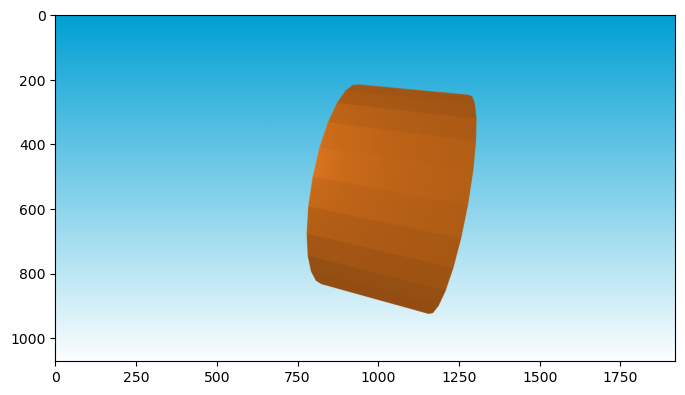

In [11]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results.

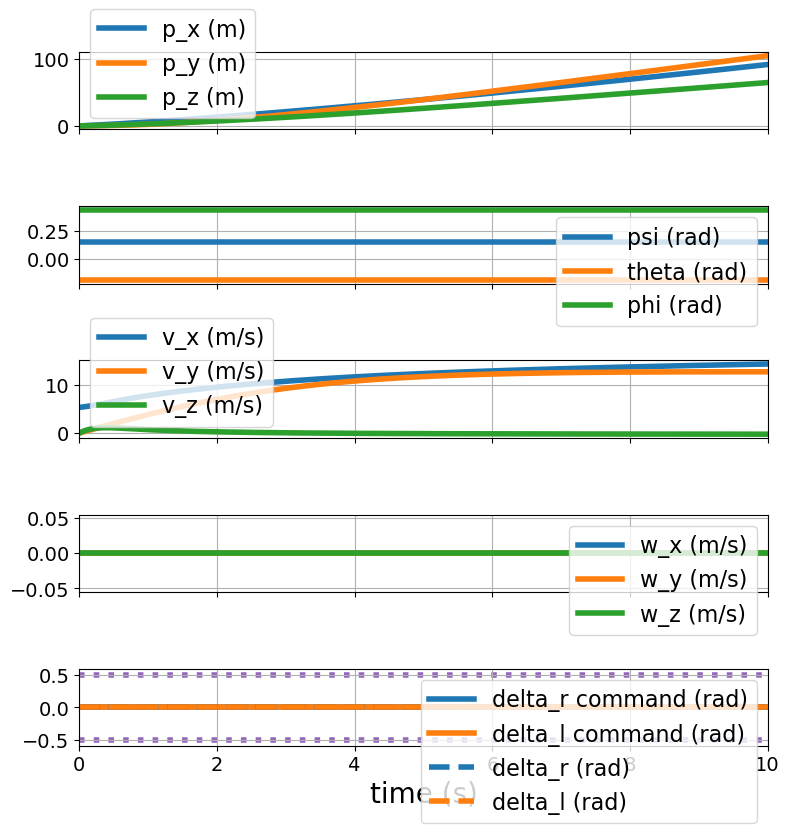

In [12]:
# Create a figure with five subplots, all of which share the same x-axis
fig, (
    ax_pos,
    ax_ori,
    ax_linvel,
    ax_angvel,
    ax_delta,
) = plt.subplots(5, 1, figsize=(8, 8), sharex=True)

# Plot position
ax_pos.plot(data['t'], data['p_x'], label='p_x (m)', linewidth=4)
ax_pos.plot(data['t'], data['p_y'], label='p_y (m)', linewidth=4)
ax_pos.plot(data['t'], data['p_z'], label='p_z (m)', linewidth=4)
ax_pos.grid()
ax_pos.legend(fontsize=16)
ax_pos.tick_params(labelsize=14)

# Plot orientation
ax_ori.plot(data['t'], data['psi'], label='psi (rad)', linewidth=4)
ax_ori.plot(data['t'], data['theta'], label='theta (rad)', linewidth=4)
ax_ori.plot(data['t'], data['phi'], label='phi (rad)', linewidth=4)
ax_ori.grid()
ax_ori.legend(fontsize=16)
ax_ori.tick_params(labelsize=14)

# Plot linear velocity
ax_linvel.plot(data['t'], data['v_x'], label='v_x (m/s)', linewidth=4)
ax_linvel.plot(data['t'], data['v_y'], label='v_y (m/s)', linewidth=4)
ax_linvel.plot(data['t'], data['v_z'], label='v_z (m/s)', linewidth=4)
ax_linvel.grid()
ax_linvel.legend(fontsize=16)
ax_linvel.tick_params(labelsize=14)

# Plot angular velocity
ax_angvel.plot(data['t'], data['w_x'], label='w_x (m/s)', linewidth=4)
ax_angvel.plot(data['t'], data['w_y'], label='w_y (m/s)', linewidth=4)
ax_angvel.plot(data['t'], data['w_z'], label='w_z (m/s)', linewidth=4)
ax_angvel.grid()
ax_angvel.legend(fontsize=16)
ax_angvel.tick_params(labelsize=14)

# Plot elevon deflection angles
ax_delta.plot(data['t'], data['delta_r_command'], label='delta_r command (rad)', linewidth=4)
ax_delta.plot(data['t'], data['delta_l_command'], label='delta_l command (rad)', linewidth=4)
ax_delta.plot(data['t'], data['delta_r'], '--', color='C0', label='delta_r (rad)', linewidth=4)
ax_delta.plot(data['t'], data['delta_l'], '--', color='C1', label='delta_l (rad)', linewidth=4)
ax_delta.plot(
    data['t'], -np.ones_like(data['t']) * simulator.maximum_elevon_deflection,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_delta.plot(
    data['t'], np.ones_like(data['t']) * simulator.maximum_elevon_deflection,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_delta.grid()
ax_delta.legend(fontsize=16)
ax_delta.tick_params(labelsize=14)
ax_delta.set_ylim(
    -1.2 * simulator.maximum_elevon_deflection,
    1.2 * simulator.maximum_elevon_deflection,
)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_delta.set_xlabel('time (s)', fontsize=20)
ax_delta.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [13]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)